In [7]:
import pandas as pd

# 1. LOADING DATA
df = pd.read_excel("../data/raw_data_pangan.xlsx", header=2)

# 2. MEMBERSIHKAN KOLOM HARGA
# Buang "Rp" dan ","
df['Harga'] = df['Harga'].astype(str).str.replace('Rp', '').str.replace(',', '')

# [PERBAIKAN DISINI]
# Tambahkan errors='coerce'.
# Artinya: Jika ketemu "-", ubah jadi NaN (Not a Number) agar tidak error.
df['Harga'] = pd.to_numeric(df['Harga'], errors='coerce')

# Hapus baris yang harganya kosong (NaN) agar tidak mengganggu prediksi
df.dropna(subset=['Harga'], inplace=True)

# 3. MEMBERSIHKAN TANGGAL
map_bulan = {
    'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04',
    'Mei': '05', 'Juni': '06', 'July': '07', 'Juli': '07',
    'Agustus': '08', 'September': '09', 'Oktober': '10',
    'November': '11', 'Desember': '12'
}

df['Bulan_Angka'] = df['Bulan'].map(map_bulan)
df['Tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + '-' + df['Bulan_Angka'] + '-01')

# Pilih kolom yang bersih saja
df_clean = df[['Tanggal', 'Komoditas', 'Harga']].copy()

# Sortir berdasarkan tanggal agar urut
df_clean = df_clean.sort_values('Tanggal')

print("Sukses! Data sudah bersih.")
print(df_clean.info())
print("\nContoh data:")
print(df_clean.head())

Sukses! Data sudah bersih.
<class 'pandas.core.frame.DataFrame'>
Index: 1078 entries, 0 to 1093
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Tanggal    1078 non-null   datetime64[ns]
 1   Komoditas  1078 non-null   object        
 2   Harga      1078 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 33.7+ KB
None

Contoh data:
      Tanggal                Komoditas    Harga
0  2021-01-01            Beras Premium  12319.0
12 2021-01-01    Minyak Goreng Kemasan  12577.0
11 2021-01-01      Tepung Terigu Curah   8291.0
10 2021-01-01   Gula Pasir Lokal/Curah  13513.0
8  2021-01-01          Daging Ayam Ras  34531.0


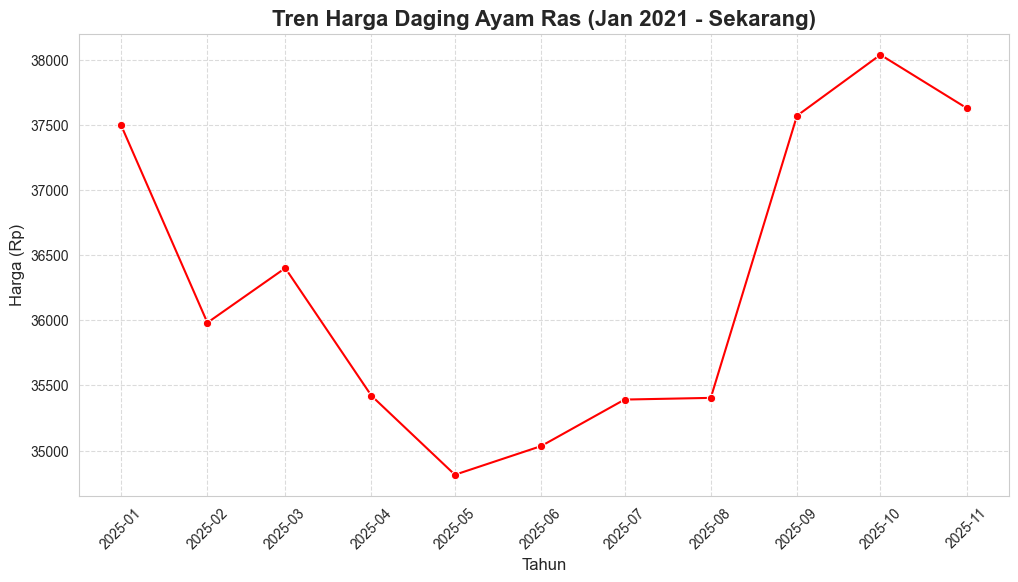

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Atur gaya grafik agar cantik
sns.set_style("whitegrid")

# 1. PILIH SATU KOMODITAS
# Kita coba cek 'Daging Ayam Ras' atau 'Cabai Merah Keriting' yang biasanya fluktuatif
# Pastikan ejaan nama komoditas SAMA PERSIS dengan data Anda
target_komoditas = 'Daging Ayam Ras' 

# Filter data hanya untuk komoditas tersebut
df_plot = df_clean[df_clean['Komoditas'] == target_komoditas]

# 2. PLOT GRAFIK
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x='Tanggal', y='Harga', marker='o', color='red')

plt.title(f'Tren Harga {target_komoditas} (Jan 2021 - Sekarang)', fontsize=16, fontweight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Harga (Rp)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.show()

19:53:08 - cmdstanpy - INFO - Chain [1] start processing
19:53:08 - cmdstanpy - INFO - Chain [1] done processing


Prediksi Harga Daging Ayam Ras ke Depan:
           ds           yhat     yhat_lower     yhat_upper
11 2025-12-01  -43665.567472  -43665.568144  -43665.566828
12 2026-01-01  122515.931296  122515.929224  122515.933435
13 2026-02-01   86697.691308   86697.687080   86697.695461
14 2026-03-01  121737.638527  121737.631575  121737.645391
15 2026-04-01  118477.152465  118477.142534  118477.161832
16 2026-05-01   99287.552309   99287.539244   99287.564497
17 2026-06-01   94891.915762   94891.898748   94891.931107
18 2026-07-01  113488.376535  113488.356048  113488.395374
19 2026-08-01  114220.787123  114220.762178  114220.809958
20 2026-09-01  107169.288978  107169.260328  107169.316558
21 2026-10-01  117911.963071  117911.930154  117911.994579
22 2026-11-01   98644.558605   98644.521819   98644.594667


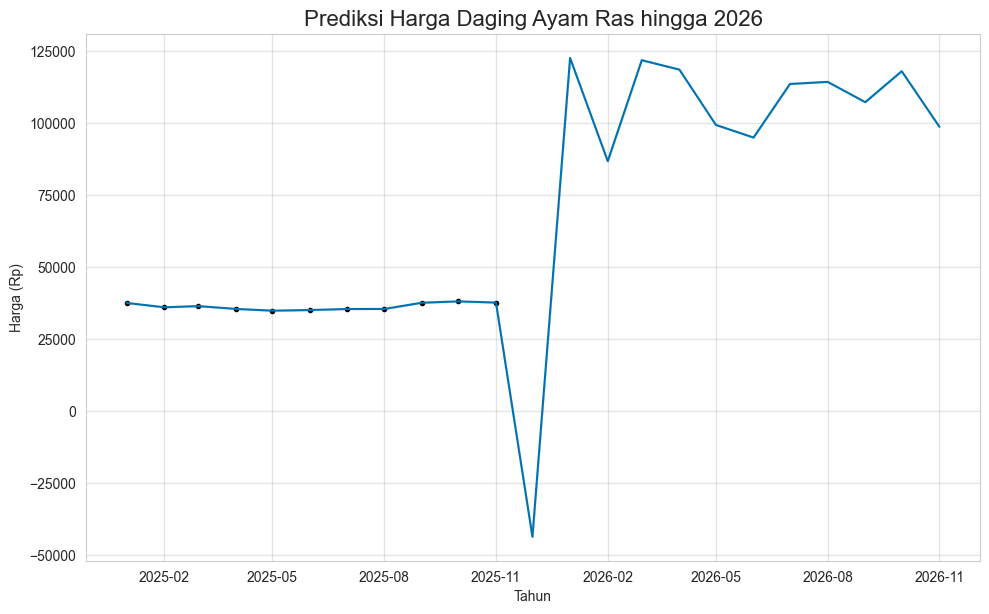

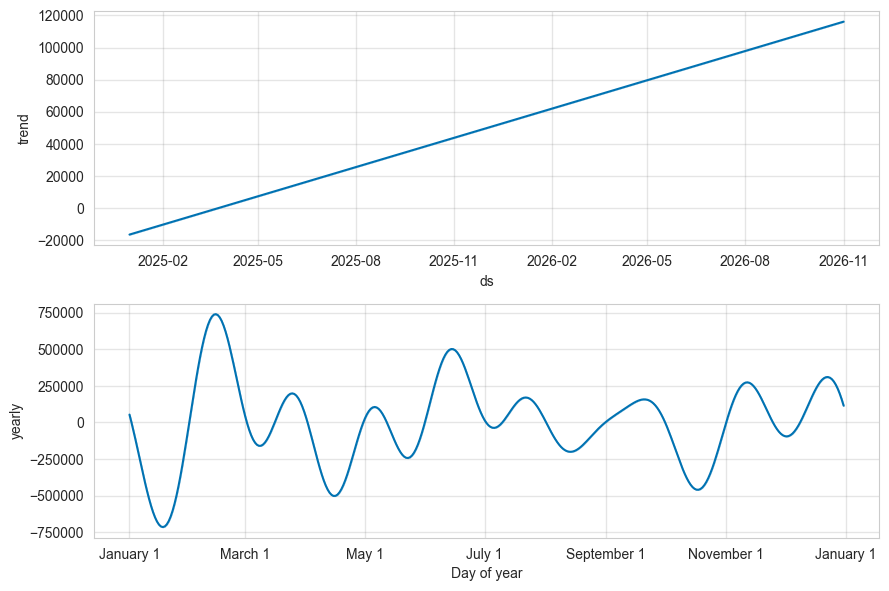

In [9]:
from prophet import Prophet

# 1. PERSIAPAN DATA
# Prophet SANGAT STRICT: Nama kolom tanggal harus 'ds', harga harus 'y'
df_train = df_clean[df_clean['Komoditas'] == target_komoditas].copy()
df_train = df_train.rename(columns={'Tanggal': 'ds', 'Harga': 'y'})

# 2. MELATIH MODEL (TRAINING)
# Kita aktifkan mode 'seasonality' agar dia paham pola tahunan
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_train)

# 3. MEMBUAT PREDIKSI KE DEPAN
# Kita ingin prediksi sampai Maret 2026.
# Hitung berapa bulan dari data terakhir Anda sampai Maret 2026.
# Anggap saja kita minta prediksi 12 bulan ke depan untuk aman.
future = model.make_future_dataframe(periods=12, freq='MS') # MS = Month Start (Awal Bulan)

# Lakukan prediksi
forecast = model.predict(future)

# 4. TAMPILKAN HASILNYA
# Ambil kolom penting: tanggal (ds), prediksi (yhat), batas bawah (yhat_lower), batas atas (yhat_upper)
hasil_prediksi = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

print(f"Prediksi Harga {target_komoditas} ke Depan:")
print(hasil_prediksi)

# 5. GAMBAR GRAFIK PREDIKSI
fig1 = model.plot(forecast)
plt.title(f"Prediksi Harga {target_komoditas} hingga 2026", fontsize=16)
plt.xlabel("Tahun")
plt.ylabel("Harga (Rp)")
plt.show()

# 6. GAMBAR KOMPONEN (PENTING!)
# Ini akan menunjukkan kapan bulan-bulan mahal (Seasonality)
fig2 = model.plot_components(forecast)
plt.show()

In [10]:
# 1. BERSIHKAN NAMA KOMODITAS (Hapus spasi di depan/belakang)
df_clean['Komoditas'] = df_clean['Komoditas'].str.strip()

# 2. CEK LAGI NAMA UNIK YANG ADA
print("Daftar Komoditas yang tersedia:")
print(df_clean['Komoditas'].unique())

# 3. SET ULANG TARGET & FILTER
target_komoditas = 'Daging Ayam Ras'  # Pastikan ejaan sama persis dengan output di atas

df_train = df_clean[df_clean['Komoditas'] == target_komoditas].copy()
df_train = df_train.rename(columns={'Tanggal': 'ds', 'Harga': 'y'})

# 4. CEK JUMLAH DATA (Harusnya sekarang > 50 baris)
print(f"\nJumlah data untuk {target_komoditas}: {len(df_train)} baris")
print("Tahun yang tersedia:", df_train['ds'].dt.year.unique())

Daftar Komoditas yang tersedia:
['Beras Premium' 'Minyak Goreng Kemasan' 'Tepung Terigu Curah'
 'Gula Pasir Lokal/Curah' 'Daging Ayam Ras' 'Daging Sapi Murni'
 'Telur Ayam Ras' 'Cabai Merah Keriting' 'Bawang Putih (Bonggol)'
 'Bawang Merah' 'Kedelai Biji Kering' 'Beras Medium' 'Cabai Rawit Merah'
 'Minyak Goreng Curah' 'Jagung Tk. Peternak' 'Ikan Tongkol' 'Ikan Kembung'
 'Ikan Bandeng' 'Tepung Terigu Kemasan' 'Garam konsumsi' 'Beras SPHP'
 'Daging Kerbau Segar (Lokal)' 'Cabai Merah Besar' 'Minyak Kita'
 'Daging Kerbau Beku (Impor)']

Jumlah data untuk Daging Ayam Ras: 59 baris
Tahun yang tersedia: [2021 2022 2023 2024 2025]


In [11]:
# Cek data mentah yang masuk ke model
print(f"Mengecek data untuk: {target_komoditas}")
print("5 Data Teratas:")
print(df_train.head())

print("\n5 Data Terbawah (Terbaru):")
print(df_train.tail())

print("\nStatistik Harga:")
print(df_train['y'].describe())

# Cek apakah ada harga yang tidak masuk akal (di atas 100.000 untuk ayam)
cek_anomali = df_train[df_train['y'] > 80000]
print(f"\nJumlah data mencurigakan (> 80rb): {len(cek_anomali)} baris")
if len(cek_anomali) > 0:
    print(cek_anomali.head())

Mengecek data untuk: Daging Ayam Ras
5 Data Teratas:
           ds        Komoditas        y
8  2021-01-01  Daging Ayam Ras  34531.0
21 2021-02-01  Daging Ayam Ras  33699.0
34 2021-03-01  Daging Ayam Ras  33457.0
47 2021-04-01  Daging Ayam Ras  36096.0
60 2021-05-01  Daging Ayam Ras  37084.0

5 Data Terbawah (Terbaru):
             ds        Komoditas        y
978  2025-07-01  Daging Ayam Ras  35391.0
1003 2025-08-01  Daging Ayam Ras  35404.0
1028 2025-09-01  Daging Ayam Ras  37569.0
1053 2025-10-01  Daging Ayam Ras  38037.0
1078 2025-11-01  Daging Ayam Ras  37628.0

Statistik Harga:
count       59.000000
mean     36136.542373
std       1400.500887
min      33457.000000
25%      35235.000000
50%      35962.000000
75%      37326.000000
max      39175.000000
Name: y, dtype: float64

Jumlah data mencurigakan (> 80rb): 0 baris


19:54:47 - cmdstanpy - INFO - Chain [1] start processing
19:54:48 - cmdstanpy - INFO - Chain [1] done processing


--- HASIL PREDIKSI MAR-APR 2026 ---
           ds          yhat    yhat_lower    yhat_upper
71 2026-12-01  36825.687318  35464.361547  38179.061565
72 2027-01-01  37399.880978  35993.248934  38685.915451
73 2027-02-01  36949.559772  35701.212839  38298.662083
74 2027-03-01  36078.317381  34775.594138  37374.296177
75 2027-04-01  36719.752852  35346.704248  38081.230607
76 2027-05-01  37895.850516  36585.845986  39188.540245


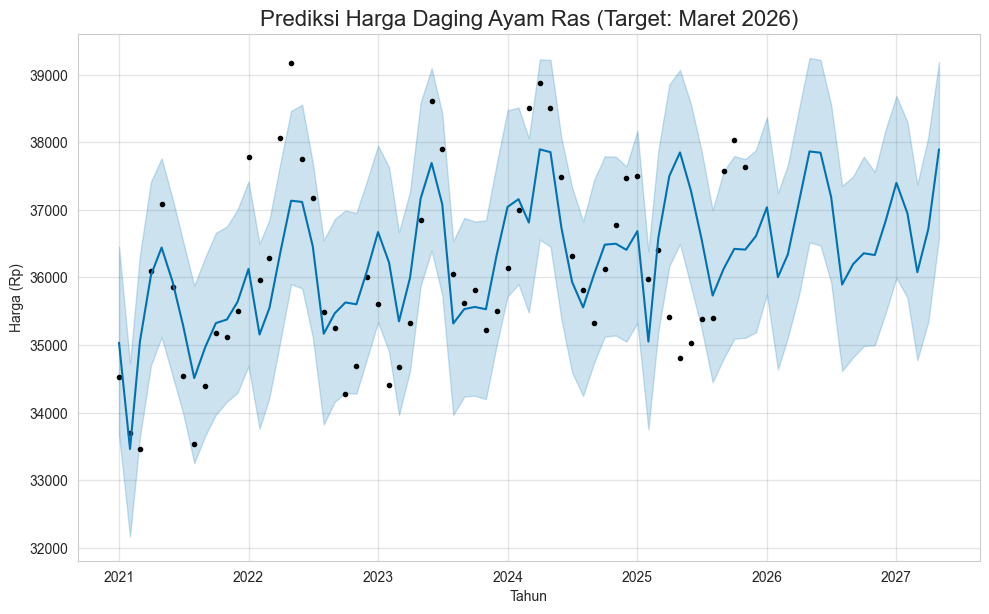

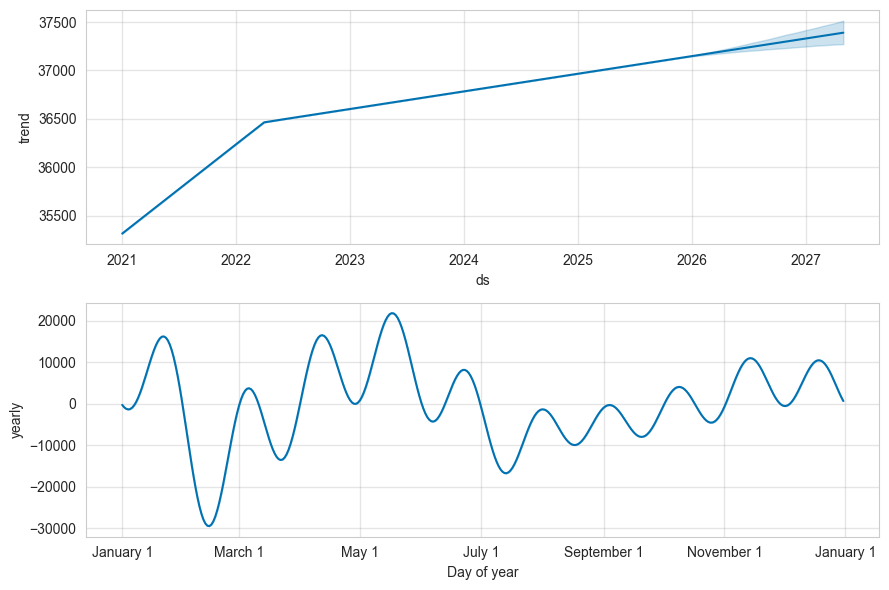

In [12]:
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. PERSIAPAN DATA FINAL
# Pastikan kita pakai data yang sudah bersih tadi
df_train = df_clean[df_clean['Komoditas'] == target_komoditas].copy()
df_train = df_train.rename(columns={'Tanggal': 'ds', 'Harga': 'y'})

# 2. LATIH MODEL
# Kita aktifkan mode 'seasonality' (musiman)
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_train)

# 3. PREDIKSI HINGGA MARET 2026
# Kita minta prediksi 18 bulan ke depan agar sampai ke pertengahan 2026
future = model.make_future_dataframe(periods=18, freq='MS') 
forecast = model.predict(future)

# 4. TUNJUKKAN ANGKA MARET 2026
print("--- HASIL PREDIKSI MAR-APR 2026 ---")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6))

# 5. PLOT GRAFIK UTAMA
fig1 = model.plot(forecast)
plt.title(f"Prediksi Harga {target_komoditas} (Target: Maret 2026)", fontsize=16)
plt.xlabel("Tahun")
plt.ylabel("Harga (Rp)")
plt.show()

# 6. PLOT KOMPONEN MUSIMAN (PENTING!)
# Perhatikan grafik kedua (Yearly) untuk melihat bulan apa biasanya harga naik
fig2 = model.plot_components(forecast)
plt.show()